# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデルと数値計算の概観

## 2.8 リスクの導入
### パラメータを設定

In [7]:
struct Models
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度

    # 要素価格
    rent::Float64 #純利子率

    # 労働所得
    y1::Float64
    y2::Float64
    y3::Float64

    # リスク
    tran::Matrix{Float64}
    endow::Vector{Float64}

    # グリッド
    na::Int64 #貯蓄グリッドの数
    ny::Int64 #所得グリッドの数
    a_max::Float64 #貯蓄グリッドの最大値
    a_min::Float64 #貯蓄グリッドの最小値
    grid_a::Vector{Float64} #貯蓄グリッド
end

In [2]:
tran = [0.7451 0.2528 0.0021; 0.1360 0.7281 0.1360; 0.0021 0.2528 0.7451]

3×3 Matrix{Float64}:
 0.7451  0.2528  0.0021
 0.136   0.7281  0.136
 0.0021  0.2528  0.7451

In [4]:
endow = [0.8027, 1, 1.2457]

3-element Vector{Float64}:
 0.8027
 1.0
 1.2457

In [11]:
function Calibration()
    # パラメータはここで設定をする
    β = 0.985^20
    γ = 2.0
    rent = 1.025^20 - 1.0
    y1 = 1.0
    y2 = 1.2
    y3 = 0.4

    tran = [0.7451 0.2528 0.0021; 0.1360 0.7281 0.1360; 0.0021 0.2528 0.7451]
    endow = [0.8027, 1, 1.2457]
    ny = 3

    na = 21
    a_max = 2.0
    a_min = 0.0

    grid_a = collect(LinRange(a_min, a_max, na))

    return Models(β, γ, rent, y1, y2, y3, tran, endow, na, ny, a_max, a_min, grid_a)
end

Calibration (generic function with 1 method)

In [12]:
params = Calibration()

Models(0.7391364333471016, 2.0, 0.6386164402903942, 1.0, 1.2, 0.4, [0.7451 0.2528 0.0021; 0.136 0.7281 0.136; 0.0021 0.2528 0.7451], [0.8027, 1.0, 1.2457], 21, 3, 2.0, 0.0, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])

---

## よく使う関数を定義

In [13]:
function mu_CRRA(cons, γ)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

In [14]:
# 使う関数を呼び出す
using Plots
pyplot()
using Optim
using Roots
using Interpolations

---

## 中年期と老年期の間の意思決定
### 中年期と老年期の間の残差関数を定義

In [15]:
function resid_three_period2(a3, a2, e2, params)

    # オイラー方程式の左辺：中年期の限界効用
    # 予算制約の右辺に基づいて手持ちの現金(cash on hand)を定義
    coh = (1 + params.rent)*a2 + params.y2*e2
    if coh - a3 > 0.0 # 消費が正値
        mu2 = mu_CRRA(coh - a3, params.γ)
    else
        mu2 = 10000.0
    end

    # 老年期の限界効用
    mu3 = mu_CRRA((1 + params.rent)*a3 + params.y3, params.γ)

    # 残差(residual)
    return params.β*(1.0 + params.rent)*(mu3/mu2) - 1.0

end

resid_three_period2 (generic function with 1 method)

In [17]:
# 空っぽの変数を用意：policy functionの器
a2_nl = zeros(params.na, params.ny)

21×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [25]:
# 実際に各w_{i}のもとで、残差関数がゼロになるようなaを探す
for (y_ind, y_val) in enumerate(params.endow)
    for (a_ind, a_val) in enumerate(params.grid_a)

        # 1変数のfunctionにする
        resid_three_period2!(a) = resid_three_period2(a, a_val, y_val, params)

        # 0.01はゼロ点を探す際の初期値
        a2_nl[a_ind, y_ind] = find_zero(resid_three_period2!, 0.01)

    end
end

print(a2_nl)

[0.24097755823532707 0.33610250165225547 0.45456270741778654; 0.3068135508711914 0.4019384942881198 0.520398700053651; 0.3726495435070557 0.46777448692398405 0.5862346926895151; 0.4384855361429199 0.5336104795598483 0.6520706853253794; 0.5043215287787842 0.5994464721957126 0.7179066779612439; 0.5701575214146485 0.6652824648315768 0.7837426705971079; 0.6359935140505127 0.7311184574674412 0.8495786632329722; 0.7018295066863771 0.7969544501033055 0.9154146558688365; 0.7676654993222416 0.8627904427391698 0.981250648504701; 0.8335014919581055 0.928626435375034 1.047086641140565; 0.8993374845939699 0.9944624280108983 1.1129226337764293; 0.9651734772298344 1.0602984206467625 1.1787586264122938; 1.0310094698656984 1.1261344132826268 1.244594619048158; 1.096845462501563 1.1919704059184912 1.3104306116840223; 1.1626814551374272 1.2578063985543553 1.3762666043198866; 1.2285174477732914 1.3236423911902198 1.4421025969557508; 1.294353440409156 1.389478383826084 1.5079385895916155; 1.36018943304502 

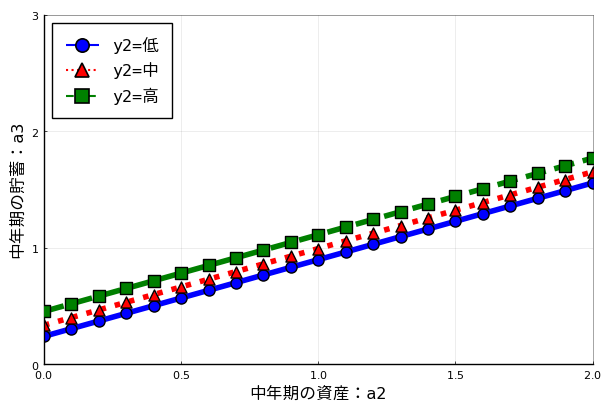

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [60]:
plt = plot(params.grid_a, a2_nl[:, 1],
    color = :blue,
    marker = :circle,
    legend = :topleft,
    xlims = (0, 2.0),
    ylims = (0, 3.0),
    label = ("y2=低"),
    xlabel = ("中年期の資産：a2"),
    ylabel = ("中年期の貯蓄：a3"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_a, a2_nl[:, 2], markershape=:utriangle, markersize = 8, linestyle = :dot, linewidth = 4, color = :red, label="y2=中")
plot!(params.grid_a, a2_nl[:, 3], markershape=:rect, markersize = 8, linestyle = :dash, linewidth = 4, color = :green, label="y2=高")
savefig("../figure/Fig2_pol_three_period23_risk.eps")

---

## 若年期と中年期の間の意思決定
### 若年期と中年期の間の残差関数を定義

In [37]:
using LinearAlgebra

In [52]:
function resid_three_period1(a2, a1, e1, a2_nl, params)

    # オイラー方程式の左辺：若年期の限界効用
    # 予算制約の右辺に基づいて手持ちの現金(cash on hand)を定義
    coh = (1 + params.rent)*a1 + params.y1*params.endow[e1]
    if coh - a2 > 0.0 # 消費が正値
        mu1 = mu_CRRA(coh - a2, params.γ)
    else
        mu1 = 10000.0
    end

    mu2 = zeros(params.ny)
    for i = 1:params.ny
        # 中年期の消費：線形補間：毎回係数を計算するのは時間の無駄なので本当は関数の外に出したほうがよい！
        interp1 = LinearInterpolation(params.grid_a, a2_nl[:, i])
        cons = interp1(a1)

        # 中年期の限界効用
        mu2[i] = mu_CRRA(cons, params.γ)
    end

    # 残差(residual)
    exp_val = dot(params.tran[e1, :], mu2)
    return params.β*(1.0 + params.rent)*(exp_val/mu1) - 1.0

end

resid_three_period1 (generic function with 1 method)

In [ ]:
# 空っぽの変数を用意：policy functionの器
a1_nl = zeros(params.na, params.ny)

In [53]:
# 実際に各w_{i}、y_{j}のもとで、残差関数がゼロになるようなaを探す
for (y_ind, y_val) in enumerate(params.endow)
    for (a_ind, a_val) in enumerate(params.grid_a)

        # 1変数のfunctionにする
        resid_three_period1!(a) = resid_three_period1(a, a_val, y_ind, a2_nl, params)

        # 0.01はゼロ点を探す際の初期値
        a1_nl[a_ind, y_ind] = find_zero(resid_three_period1!, 0.01)

    end
end

print(a1_nl)

[0.5687020671181258 0.7043448572093493 0.8709781493506432; 0.671565795322419 0.8061834589217451 0.9733144358502718; 0.7747566830037368 0.9087067827302273 1.0761182859834397; 0.8781554874120827 1.0116313545570574 1.1792201569347767; 0.9816943856562066 1.1148133156716977 1.2825238257050546; 1.0853320676275862 1.2181712037759695 1.3859705028739937; 1.1890419726317425 1.32165512435575 1.4895222169257178; 1.29280626108589 1.4252326646355877 1.5931533433454277; 1.3966125130376372 1.5288817816057922 1.696845962583042; 1.5004518183285225 1.6325869245182445 1.8005871667908393; 1.604317620073085 1.7363367880965965 1.9043674226354321; 1.7082049866415219 1.8401229446441854 2.008179536528137; 1.812110137899325 1.9439389764149637 2.1120179785694138; 1.9160301279020933 2.047779905972187 2.21587842805209; 2.019962626959427 2.151641811005135 2.319757460205296; 2.123905768588538 2.255521557153796 2.4236523254995337; 2.2278580398960632 2.359416608518249 2.527560791107364; 2.33181820166793 2.4633248906036

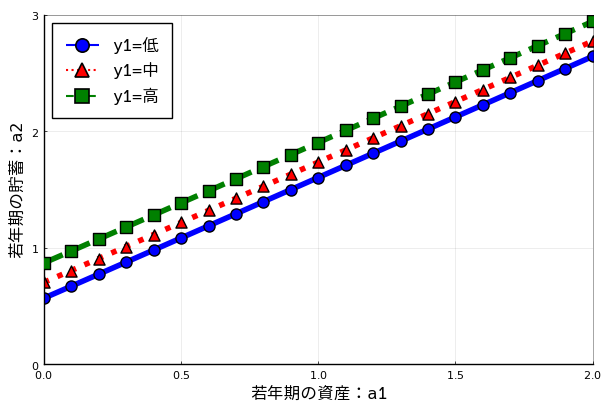

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [62]:
plt = plot(params.grid_a, a1_nl[:, 1],
    color = :blue,
    marker = :circle,
    legend = :topleft,
    xlims = (0, 2.0),
    ylims = (0, 3.0),
    label = ("y1=低"),
    xlabel = ("若年期の資産：a1"),
    ylabel = ("若年期の貯蓄：a2"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_a, a1_nl[:, 2], markershape=:utriangle, markersize = 8, linestyle = :dot, linewidth = 4, color = :red, label="y1=中")
plot!(params.grid_a, a1_nl[:, 3], markershape=:rect, markersize = 8, linestyle = :dash, linewidth = 4, color = :green, label="y1=高")
savefig("../figure/Fig2_pol_three_period12_risk.eps")